In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import cv2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# Set up ImageDataGenerator with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=30,  # Rotate images by up to 30 degrees
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,  # Shear angle in counter-clockwise direction
    zoom_range=0.2,  # Zoom in/out
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill missing pixels after transformation
)

# no split the dataset, use the same directory for both train and validation
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/temp-data-facerec/PImg',  # Path to the root dataset folder
    target_size=(224, 224),  # Resize images to 224x224 (VGG16 input size)
    batch_size=32,
    class_mode='binary',  # Binary classification (familiar or unfamiliar)
    shuffle=True  # Shuffle to ensure variety
)


Found 60 images belonging to 1 classes.


In [3]:
# Load VGG16 pre-trained on ImageNet (without the top classification layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of VGG16 to avoid updating during training (since we want to overfit on our dataset)
for layer in base_model.layers:
    layer.trainable = False

# Build the full model on top of VGG16
model = models.Sequential([
    base_model,  # Base VGG16 model
    layers.Flatten(),  # Flatten the 3D output to 1D
    layers.Dense(512, activation='relu'),  # Fully connected layer with 512 units
    layers.Dense(1, activation='sigmoid')  # Output layer with a single neuron (for binary classification)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Train the model using the full dataset (no validation split)
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,  # Adjust the number of epochs as needed
    callbacks=[EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)]  # Early stopping if loss stops improving
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.1786 - loss: 0.8485
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 1.0000 - loss: 5.0005e-18
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 4/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 1.0000 - loss: 9.6899e-29
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 3.0013e-37
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 1.0000 - loss: 4.2039e-45
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.0000e+00


In [5]:
# Evaluate the model on the training data
train_loss, train_accuracy = model.evaluate(train_generator)
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 1.0000 - loss: 2.0370e-26
Training Loss: 1.577449869133876e-26
Training Accuracy: 1.0


In [6]:
# Save the trained model
model.save('familiar_face_recognition_model.h5')


In [12]:
# Initialize lists to store true labels and predictions
y_true_val = []
y_pred_val = []
y_prob_val = []

# Set the number of iterations (one for each image in the dataset)
num_images = 60  # Adjust if the number of images changes
for i in range(num_images):
    images, labels = next(train_generator)  # Get the next batch of images
    predictions = model.predict(images)
    
    # Store true labels and predicted labels/probabilities
    y_true_val.extend(labels)
    y_pred_val.extend((predictions >= 0.5).astype(int))  # 0 or 1 based on the threshold of 0.5
    y_prob_val.extend(predictions)

# Now, you can proceed with confusion matrix and ROC curve plotting


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

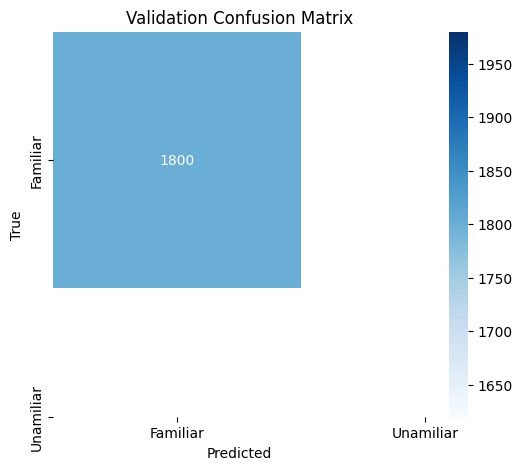

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm_val = confusion_matrix(y_true_val, y_pred_val)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=['Familiar', 'Unamiliar'], yticklabels=['Familiar', 'Unamiliar'])
plt.title("Validation Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


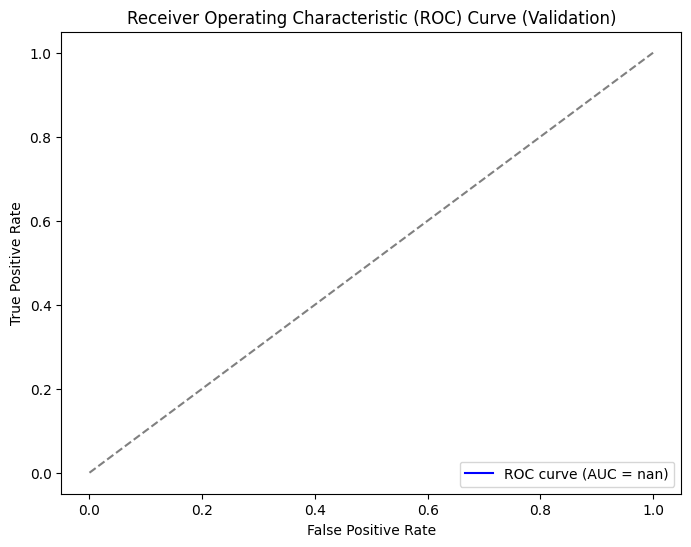

In [20]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC for validation
fpr_val, tpr_val, thresholds_val = roc_curve(y_true_val, y_prob_val)
roc_auc_val = auc(fpr_val, tpr_val)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_val, tpr_val, color='blue', label=f'ROC curve (AUC = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.title('Receiver Operating Characteristic (ROC) Curve (Validation)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [16]:
from sklearn.metrics import classification_report

# Print classification report for validation
print(classification_report(y_true_val, y_pred_val, target_names=[ 'Familiar']))


              precision    recall  f1-score   support

    Familiar       1.00      1.00      1.00      1800

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800

